In [1]:
import numpy as np
import paddle
import matplotlib.pyplot as plt#用于绘图
from PIL import Image#用于绘图

2020-07-14 11:05:27,060-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-07-14 11:05:27,412-INFO: generated new fontManager


查看MNIST数据样例，仅用一张图做展示
（代码无需掌握，仅需对数据集有所了解）

MNIST是一个手写数字数据库，它有60000个训练样本集和10000个测试样本集。它是NIST数据库的一个子集。

         MNIST数据库官方网址为：[http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/) ，也可以在windows下直接下载，train-images-idx3-ubyte.gz、train-labels-idx1-ubyte.gz等。下载四个文件，解压缩。解压缩后发现这些文件并不是标准的图像格式。这些图像数据都保存在二进制文件中。每个样本图像的宽高为28*28。

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


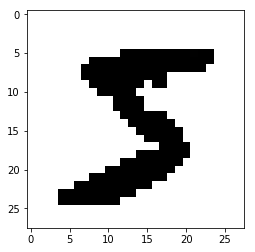

In [2]:
temp_reader = paddle.batch(paddle.dataset.mnist.train(), batch_size=1)#仅加载第一张图
temp_data=next(temp_reader())#加载一张图
temp_data = np.reshape(temp_data[0][0],[28,28])#将list格式的数据转化为28*28
image1 = temp_data.astype("uint8")#设置图片数据格式为无符号整数
img = Image.fromarray(image1)#将矩阵转化为图片格式
plt.imshow(img)#设置图片
plt.show()#展示图片

Fluid的字面意思是流动、流体，意思和tensorflow的flow有点意思，都暗指数据流流动。

Fluid和Tensorflow最大的区别是Fluid把模型定义为由多个程序块组成的程序，每个程序块完成一系列计算。

而Tensorflow将模型定义为一张计算图，图中每一部分是数据的流向与计算。Fluid从程序员的视角和习惯来设计，Tensorflow更倾向于数据科学者的视角。

知乎上一篇文章对此的介绍不错：[PaddleFluid和TensorFlow基本使用概念对比](https://zhuanlan.zhihu.com/p/38290380)。

下面的实例展示了一个卷积神经网络的定义方式

一个CNN模型被定义为一个类。这个类里面包含两个函数：_init_和forword

首先_init_ 函数定义了模型的各层，相当于Tensorflow计算图中的各个节点。

而forward函数则定义了各层之间的连结方式，也就是张量的流动方向。之所以叫forward，是因为这也是神经网络中数据前向传播的方向。

这个简单的CNN网络仅包含两个卷积层和两个池化层。

我们先在_init_中定义各层。

> self.conv1 = Conv2D(num_channels=1, num_filters=32, filter_size=3, act='sigmoid')

num_channels表示输入数据的通道数（数据经过几个卷积核/filter，就有多少通道数）。由于我们这是第一个卷积层，还没经历过filter，所以channel数为1。

然后我们这一层使用32个卷积核filter，卷积核尺寸3\*3，激活函数sigmoid。卷积核数和卷积核尺寸不是不是唯一，可以自己调整，我们只是展示一个尝试了很多次后得到的一个比较好的参数。

经过第一个卷积层后，图片的尺寸从28\*28转为26\*26（28-3+1）\*32。

然后我们再定义一个池化层：

> self.pool1 = Pool2D(pool_size=2, pool_stride=1, pool_type='max')

pool_size=2表示池化层降采样的核使用的尺寸是2\*2，pool_stride=1表示每次降采样后向旁边滑动一个像素。pool_type='max'表示降采样的方式是取2\*2区域中的最大值。例如[254,231,153,142]经过降采样后只保留一个数字254。经过这层后数据的尺寸为25\*25\*32。25=26/1-2+1。

经过第二个卷积核后，数据尺寸为23\*23（25-3+1）\*64。

经过第二个池化层后，数据尺寸为22\*22（23/1-2+1）\*64。转为一维的话是30976\*1。

最后一层是全连层，全连层的输入不是矩阵，而是一个序列，是一维的。所以要把之前的张量转为一维数据。
> self.fc1 = Linear(input_dim=30976, output_dim=num_classes)

30976根据上面计算得出，num_classes是手写体数字的种类，从0到9，十种。

第二个函数是forward函数，要把各层连结起来。这个很像Keras的Model形式。

>注意 x = fluid.layers.reshape(x, [x.shape[0], -1])这一行。

这里进行reshape操作是因为pool2层的输出是22\*22\*64，而全连层要求的输入是一维的，所以要把矩阵reshape成一维。

In [3]:
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear

# 定义 CNN 网络结构
class CNN(fluid.dygraph.Layer):
    def __init__(self, num_classes=1):
        super(CNN, self).__init__()

        # 创建卷积和池化层块，每个卷积层使用Sigmoid激活函数，后面跟着一个2x2的池化
        self.conv1 = Conv2D(num_channels=1, num_filters=32, filter_size=3, act='sigmoid')
        self.pool1 = Pool2D(pool_size=2, pool_stride=1, pool_type='max')
        self.conv2 = Conv2D(num_channels=32, num_filters=64, filter_size=3, act='sigmoid')
        self.pool2 = Pool2D(pool_size=2, pool_stride=1, pool_type='max')
        self.fc1 = Linear(input_dim=30976, output_dim=num_classes)

    # 网络的前向计算过程
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        return x

后面就是训练过程，这个过程比较流程化，在其他项目中比较好迁移。

>  with fluid.dygraph.guard():

表示后面使用动态图

> model = CNN(num_classes=10)
定义模型

> train(model)
 启动训练过程

> epoch_num = 12
表示训练12轮，大家可以自己加减看效果

> opt = fluid.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameter_list=model.parameters())

这里学习率为0.001，动量为0.9（用于跳出局部最小值）。

> train_loader = paddle.batch(paddle.dataset.mnist.train(), batch_size=10)
valid_loader = paddle.batch(paddle.dataset.mnist.test(), batch_size=10)

加载数据

> loss = fluid.layers.softmax_with_cross_entropy(logits, label)

定义损失函数为交叉熵函数

In [4]:
# 定义训练过程
def train(model):
    print('start training ... ')
    model.train()
    epoch_num = 12
    opt = fluid.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameter_list=model.parameters())
    # 使用Paddle自带的数据读取器
    train_loader = paddle.batch(paddle.dataset.mnist.train(), batch_size=10)
    valid_loader = paddle.batch(paddle.dataset.mnist.test(), batch_size=10)
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            # 调整输入数据形状和类型
            x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 1, 28, 28)
            y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)
            # 将numpy.ndarray转化成Tensor
            img = fluid.dygraph.to_variable(x_data)
            label = fluid.dygraph.to_variable(y_data)
            # 计算模型输出
            logits = model(img)
            # 计算损失函数
            loss = fluid.layers.softmax_with_cross_entropy(logits, label)
            avg_loss = fluid.layers.mean(loss)
            if batch_id % 1000 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            avg_loss.backward()
            opt.minimize(avg_loss)
            model.clear_gradients()

        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            # 调整输入数据形状和类型
            x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 1, 28, 28)
            y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)
            # 将numpy.ndarray转化成Tensor
            img = fluid.dygraph.to_variable(x_data)
            label = fluid.dygraph.to_variable(y_data)
            # 计算模型输出
            logits = model(img)
            pred = fluid.layers.softmax(logits)
            # 计算损失函数
            loss = fluid.layers.softmax_with_cross_entropy(logits, label)
            acc = fluid.layers.accuracy(pred, label)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
        model.train()

    # 保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')


if __name__ == '__main__':
    # 创建模型
    with fluid.dygraph.guard():
        model = CNN(num_classes=10)
        #启动训练过程
        train(model)

start training ... 


Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


epoch: 0, batch_id: 0, loss is: [2.7852263]
epoch: 0, batch_id: 1000, loss is: [0.10298177]
epoch: 0, batch_id: 2000, loss is: [0.2644323]
epoch: 0, batch_id: 3000, loss is: [0.01399288]
epoch: 0, batch_id: 4000, loss is: [0.03530569]
epoch: 0, batch_id: 5000, loss is: [0.15203491]
[validation] accuracy/loss: 0.929900050163269/0.23405927419662476
epoch: 1, batch_id: 0, loss is: [0.05236039]
epoch: 1, batch_id: 1000, loss is: [0.02579585]
epoch: 1, batch_id: 2000, loss is: [0.02599655]
epoch: 1, batch_id: 3000, loss is: [0.00830223]
epoch: 1, batch_id: 4000, loss is: [0.01651256]
epoch: 1, batch_id: 5000, loss is: [0.04333802]
[validation] accuracy/loss: 0.9601999521255493/0.12818966805934906
epoch: 2, batch_id: 0, loss is: [0.02193589]
epoch: 2, batch_id: 1000, loss is: [0.0117144]
epoch: 2, batch_id: 2000, loss is: [0.01779418]
epoch: 2, batch_id: 3000, loss is: [0.02125602]
epoch: 2, batch_id: 4000, loss is: [0.01673141]
epoch: 2, batch_id: 5000, loss is: [0.01332028]
[validation] ac